In [ ]:
#Mount the Drive to access dataset
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Locate the Dataset
%cd /content/gdrive/MyDrive/work/'01. Projects'/Canine

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/work/01. Projects/Canine'
/content


In [ ]:
ls

data/  github_examples/  model_experiments/  testing_and_data_exploration/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from  sklearn.preprocessing import MinMaxScaler
import random
import time
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import argparse
# import tensorflow.compat.v1 as tf
# import tensorflow_addons as tfa
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from  sklearn.preprocessing import MinMaxScaler
import random
import time
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix
# import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import argparse


# from tensorflow.keras.optimizers.legacy import Adam
# # tf.disable_v2_behavior()
# tf.compat.v1.disable_v2_behavior()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os

from scipy import signal

"""
    Old split
    train = [df101, df107, df201, df407, df413]
    test = [df100, df301, df403, df404]

    Train
    df100 = [N2096, S0, V1305] - Train
    df101 = [N2129, S0, V3] - Train
    df107 = [N6216, S0, V857] - Train
    df201 = [N145349, S2412, V1] - Test
    df403 = [N22598, S0, V9170] - Train
    df301 = [N0, S4821, V10] - Train

    Test
    df404 = [N0, S0, V24096] - Test
    df407 = [N0, S0, V5871] - Train
    df413 = [N0, S1373, V0] - Test

"""
# Data
data_100 = pd.read_csv('sash_data/data/100.csv', header=None)
data_101 = pd.read_csv('sash_data/data/101.csv', header=None)
data_107 = pd.read_csv('sash_data/data/107.csv', header=None)
data_201 = pd.read_csv('sash_data/data/201.csv', header=None)
data_301 = pd.read_csv('sash_data/data/301.csv', header=None)
data_403 = pd.read_csv('sash_data/data/403.csv', header=None)
data_404 = pd.read_csv('sash_data/data/404.csv', header=None)
data_405 = pd.read_csv('sash_data/data/405.csv', header=None)
data_407 = pd.read_csv('sash_data/data/407.csv', header=None)
data_413 = pd.read_csv('sash_data/data/413.csv', header=None)


# labels
labels_100 = pd.read_csv('sash_data/labels/100_labels.csv')
labels_101 = pd.read_csv('sash_data/labels/101_labels.csv')
labels_107 = pd.read_csv('sash_data/labels/107_labels.csv')
labels_201 = pd.read_csv('sash_data/labels/201_labels.csv')
labels_301 = pd.read_csv('sash_data/labels/301_labels.csv')
labels_403 = pd.read_csv('sash_data/labels/403_labels.csv')
labels_404 = pd.read_csv('sash_data/labels/404_labels.csv')
labels_405 = pd.read_csv('sash_data/labels/405_labels.csv')
labels_407 = pd.read_csv('sash_data/labels/407_labels.csv')
labels_413 = pd.read_csv('sash_data/labels/413_labels.csv')


# # Custom
custom_100 = pd.read_csv('sash_data/custom/100_custom.csv')
custom_101 = pd.read_csv('sash_data/custom/101_custom.csv')
custom_107 = pd.read_csv('sash_data/custom/107_custom.csv')
custom_201 = pd.read_csv('sash_data/custom/201_custom.csv')
custom_403 = pd.read_csv('sash_data/custom/403_custom.csv')



# df name
labels_100.name = '100'
labels_101.name = '101'
labels_107.name = '107'
labels_201.name = '201'
labels_301.name = '301'
labels_403.name = '403'
labels_404.name = '404'
labels_405.name = '405'
labels_407.name = '407'
labels_413.name = '413'


<Axes: >

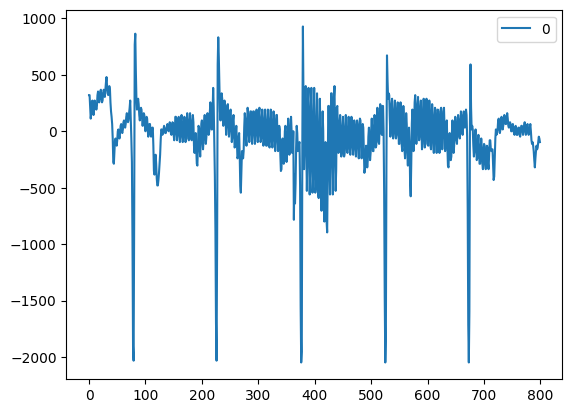

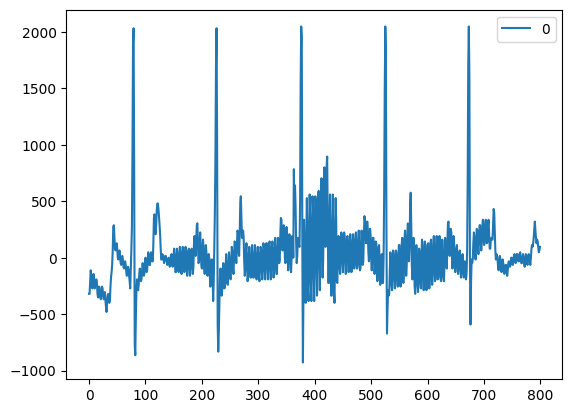

In [ ]:
import matplotlib.pyplot as plt
dog_data_short = data_413[:800]
dog_data_short.plot.line()
invert_signal = dog_data_short * -1  # imports and inverts data
invert_signal.plot.line()

In [ ]:
#check the length of each label and data points
print(len(data_100),len(labels_100))
#len(custom_100))
print(len(data_101),len(labels_101))
#len(custom_101))
print(len(data_107),len(labels_107))
#len(custom_107))
print(len(data_201),len(labels_201))
#len(custom_201))
print(len(data_301),len(labels_301))
print(len(data_403),len(labels_403))
#len(custom_403))
print(len(data_404),len(labels_404))
print(len(data_405),len(labels_405))
print(len(data_407),len(labels_407))
print(len(data_413),len(labels_413))

22103040 126028
22103040 110143
22103040 148619
22103040 147764
22103040 138751
22103040 108244
22103040 105549
22103040 99547
22103040 124817
22103040 95529


In [ ]:
# Butterworth bandpass
def filter_signal(data, low, high):
    fc_low = 2 * low / 256  # highpass
    fc_high = 2 * high / 256  # lowpass

    b, a = signal.butter(2, [fc_low, fc_high], btype='bandpass')
    # b, a = signal.butter(filter_order, fc_high, btype='low')

    # filtfilt applies the same filter twice
    filtered_data = signal.filtfilt(b, a, data, axis=0)  # lfilter is phase shifting and for 'online'

    return filtered_data

In [ ]:
# Revised dataset
def generate_data(custom, labels, input_data):
    data = np.concatenate(input_data.to_numpy().tolist())
    # data = filter_signal(data, 1, 30)
    datapoint = []

    for i in range(len(custom)):
        try:
            qrs = custom.Samples[i] #start of the qrs complex
            qrs_index = labels.loc[labels.Samples == qrs].index[0]
            if custom.Label[i] != 'N':
                left = int(labels.Samples[qrs_index - 1] + 20)
                right = int(labels.Samples[qrs_index + 1])
            else:
                left = int(labels.Samples[qrs_index] - ((labels.Samples[qrs_index]-labels.Samples[qrs_index - 1])/2.5))
                right = int(labels.Samples[qrs_index] + ((labels.Samples[qrs_index + 1]-labels.Samples[qrs_index])/1.5))

            heartbeat = data[left:right] * -1
            filtered_heartbeat = filter_signal(heartbeat, 1, 30)
            resampled_heartbeat = signal.resample(filtered_heartbeat, 256)

            _data = {'Label': custom.Label[i], 'Form': custom.Form[i], 'Filename': labels.name, 'QRS': qrs,
                     'Heartbeat': resampled_heartbeat}

            datapoint.append(_data)
        except:
            KeyError

    df = pd.DataFrame(datapoint)
    return df



In [ ]:
# Plot data n * m
def plot_data(data, n, m):
    for i in range(len(data)):
        fig, ax = plt.subplots(n, m)
        ax = ax.flatten()
        x = i * n * m
        for j in range(n * m):
            ax[j].plot(data.Heartbeat[x + j])
            ax[j].set_title(str(data.Label[x + j]) + '|' + str(data['Filename'][x + j] + '|' + str(data['QRS'][x + j])))
        # plt.tight_layout()
        plt.show()

In [ ]:
#""" TAKEN FROM ECG DATALOADER EXAMPLE"
# """
#   203 - Keep only N1, N2, N3 = 7620 beats
#   405 - N1(24771) N3(17120) V2(4824) V3(1123)
# """

# Custom
df100 = generate_data(custom_100, labels_100, data_100)
df101 = generate_data(custom_101, labels_101, data_101)
df107 = generate_data(custom_107, labels_107, data_107)
df201 = generate_data(custom_201, labels_201, data_201)
df403 = generate_data(custom_403, labels_403, data_403)

# All
df301 = generate_data(labels_301, labels_301, data_301)
df404 = generate_data(labels_404, labels_404, data_404)
df405 = generate_data(labels_405, labels_405, data_405)
df407 = generate_data(labels_407, labels_407, data_407)
df413 = generate_data(labels_413, labels_413, data_413)

df403n = df403.loc[df403.Label == 'N']
df403n = df403n.drop(df403n.loc[df403n.Form != 'N2'].index)
df403 = df403.drop(df403.loc[df403.Label == 'N'].index)
df403 = pd.concat([df403n, df403])

df201 = df201.drop(df201.loc[df201.Label == 'N'].index)
df301 = df301.drop(df301.loc[df301.Label == 'N'].index)
df404 = df404.drop(df404.loc[df404.Label == 'N'].index)
df405 = df405.drop(df405[(df405.Form != 'N1') & (df405.Form != 'V2') & (df405.Form != 'V3')].index)
df407 = df407.drop(df407.loc[df407.Label == 'N'].index)
df413 = df413.drop(df413.loc[df413.Label == 'N'].index)

train = [df101, df107, df301, df403, df407]
test = [df404, df405, df413]

training = pd.DataFrame(df100)
testing = pd.DataFrame(df201)

for i in range(len(train)):
  print(train[i].Label.value_counts())
  training = pd.concat([training, train[i]], ignore_index=True)

for i in range(len(test)):
  print(test[i].Label.value_counts())
  testing = pd.concat([testing, test[i]], ignore_index=True)

# Removes empty lists
training = training[training.Heartbeat.str.len() > 0]
testing = testing[testing.Heartbeat.str.len() > 0]

# Drop NaN
training = training[training['Form'].notna()].reset_index(drop=True)
testing = testing[testing['Form'].notna()].reset_index(drop=True)


training.to_pickle('model_experiments/Experiment 5/exp_saved_data/sash_train_custom.pkl')
testing.to_pickle('model_experiments/Experiment 5/exp_saved_data/sash_test_custom.pkl')

Label
N    2129
V       3
Name: count, dtype: int64
Label
N    6216
V     857
Name: count, dtype: int64
Label
S    4821
V      10
Name: count, dtype: int64
Label
N    22598
V     9168
Name: count, dtype: int64
Label
V    5871
Name: count, dtype: int64
Label
V    24066
Name: count, dtype: int64
Label
N    24766
V     5947
Name: count, dtype: int64
Label
S    1373
Name: count, dtype: int64


In [ ]:
#plot_data(df101, 1, 2)
#plot_data(training[training.Label == 'N'].sample(frac=1).reset_index(drop=True), 10, 6)

In [ ]:
#training = SD20 Divison
training = pd.read_pickle('model_experiments/Experiment 5/exp_saved_data/sash_train_custom.pkl')

training

,Label,Form,Filename,QRS,Heartbeat
0,V,V1,100,4662218,"[85.32069795388132, 119.09482429607219, 2.3239..."
1,V,V1,100,4662279,"[26.169530589169515, 68.04847552071413, -2.024..."
2,V,V1,100,4662337,"[58.11609988144101, 135.4206451198308, 75.3172..."
3,V,V1,100,4662398,"[45.63926199194053, 123.61965578690037, 59.478..."
4,V,V1,100,4662458,"[46.076016742780496, 129.85339944369798, 69.10..."
...,...,...,...,...,...
46836,V,V1,407,19240967,"[-4.262776821733564, -8.14708280607032, -10.61..."
46837,V,V3,407,19241284,"[0.9165241673537345, 330.87316265504563, 737.6..."
46838,V,V1,407,19241561,"[-3.0033146654294387, 4.762475191756665, 10.31..."
46839,V,V1,407,19446105,"[10.080387437791154, 26.76082430703887, 34.350..."


In [ ]:
training['Label'].unique()

array(['V', 'N', 'S'], dtype=object)

In [ ]:
unique, counts = np.unique(training['Label'], return_counts=True)
list(zip(unique.tolist(), counts.tolist()))

[('N', 32298), ('S', 3654), ('V', 10889)]

In [ ]:
testing = pd.read_pickle('model_experiments/Experiment 5/exp_saved_data/sash_test_custom.pkl')
testing

,Label,Form,Filename,QRS,Heartbeat
0,S,S1,201,53821,"[2.5029670631221217, -18.638949993365664, -39...."
1,S,S1,201,53905,"[-6.5481938034095535, -29.515037307603, -46.63..."
2,S,S1,201,55337,"[18.471673602975816, 10.922614322821483, 2.121..."
3,S,S1,201,63425,"[-15.77094638569321, -61.31224977819674, -102...."
4,S,S1,201,63726,"[-38.54194056109834, -64.46393674463202, -69.9..."
...,...,...,...,...,...
56707,S,S1,413,4975011,"[-41.36736814363741, -31.37399570397997, -0.01..."
56708,S,S1,413,5522205,"[-98.18165825792197, -134.81197250348896, -137..."
56709,S,S1,413,9308063,"[-15.187437096919808, -5.488337100291964, 15.1..."
56710,S,S1,413,9967681,"[-51.45517004483305, -10.37580675706787, 35.60..."


In [ ]:

unique, counts = np.unique(testing['Label'], return_counts=True)
list(zip(unique.tolist(), counts.tolist()))

[('N', 24766), ('S', 3164), ('V', 28782)]

In [ ]:
# [('N', 24766), ('S', 3164), ('V', 28782)] #testing
# [('N', 32298), ('S', 3654), ('V', 10889)] #training

In [ ]:
# training.to_pickle('model_experiments/Experiment 5/exp_saved_data/sash_train_custom.pkl')
# testing.to_pickle('model_experiments/Experiment 5/exp_saved_data/sash_test_custom.pkl')